In [1]:
using Plots
using LinearAlgebra
using BenchmarkTools
using SparseArrays

# Week 4 - Boundary Value Problems and the Finite Difference Method
## Kiran Shila - U54532811

## Part 1 - Finite Difference Laplace Equation

So first we are going to write the function that calculates the "A" Matrix that describes the operator on the source vector b

For this function, I am going to allow the user to input the "dirichlet" conditions for the top and bottom bounds in 1D

In [2]:
"""
    generate1DLaplaceCFD(length,lowerBound,upperBound)

    This function generates the 1D centered finite-difference to solve the laplace equation.
"""
function generate1DLaplaceCFD(length::Int64)
    mainDiagonal = fill(2,length)
    sideDiagonals = fill(-1,length-1)
    return SymTridiagonal(mainDiagonal,sideDiagonals)
end

generate1DLaplaceCFD

In [3]:
A = generate1DLaplaceCFD(100)

100×100 SymTridiagonal{Int64,Array{Int64,1}}:
  2  -1   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅  …   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅
 -1   2  -1   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅      ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅
  ⋅  -1   2  -1   ⋅   ⋅   ⋅   ⋅   ⋅      ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅
  ⋅   ⋅  -1   2  -1   ⋅   ⋅   ⋅   ⋅      ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅
  ⋅   ⋅   ⋅  -1   2  -1   ⋅   ⋅   ⋅      ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅
  ⋅   ⋅   ⋅   ⋅  -1   2  -1   ⋅   ⋅  …   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅
  ⋅   ⋅   ⋅   ⋅   ⋅  -1   2  -1   ⋅      ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅
  ⋅   ⋅   ⋅   ⋅   ⋅   ⋅  -1   2  -1      ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅
  ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅  -1   2      ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅
  ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅  -1      ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅
  ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅  …   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅
  ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅      ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅
  ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅      ⋅   ⋅   ⋅   ⋅

Now we generate the source vector $\vec{B}$

The first entry is the lower bound, 0V and the upper bound is 1V

In [4]:
b = [1;zeros(98);0]

100-element Array{Float64,1}:
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮  
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

And solve - I'm using LAPACK's solver, thats why the type of A is SymTridiagonal, there are special solvers for it.

In [5]:
x = A\b

100-element Array{Float64,1}:
 0.9900990099009893  
 0.9801980198019786  
 0.970297029702968   
 0.9603960396039576  
 0.950495049504947   
 0.9405940594059363  
 0.9306930693069255  
 0.920792079207915   
 0.9108910891089045  
 0.900990099009894   
 0.8910891089108834  
 0.8811881188118728  
 0.8712871287128622  
 ⋮                   
 0.11881188118811689 
 0.1089108910891072  
 0.0990099009900975  
 0.0891089108910878  
 0.07920792079207808 
 0.06930693069306836 
 0.059405940594058605
 0.04950495049504884 
 0.039603960396039084
 0.029702970297029313
 0.019801980198019542
 0.009900990099009771

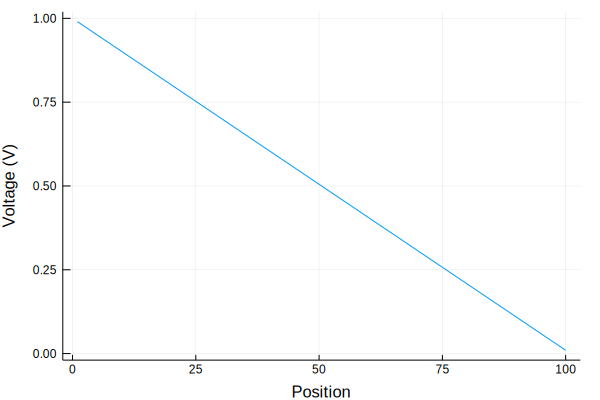

In [6]:
plot(x,legend=false,xlabel="Position",ylabel="Voltage (V)")

Hey look, it's linear - as it should be.

Lets compare the speed when we ramp up the number of points for the different implementations.

First as the built-in tridiagonal type

In [7]:
numPoints = 100
A = generate1DLaplaceCFD(numPoints)
b = [0;fill(0,numPoints-2);1]
time1 = @benchmark A\b

BenchmarkTools.Trial: 
  memory estimate:  2.67 KiB
  allocs estimate:  5
  --------------
  minimum time:     1.858 μs (0.00% GC)
  median time:      2.361 μs (0.00% GC)
  mean time:        4.008 μs (32.32% GC)
  maximum time:     8.723 ms (99.95% GC)
  --------------
  samples:          10000
  evals/sample:     10

Now as the generic "sparse" matrix

In [8]:
numPoints = 100
A = sparse(float(generate1DLaplaceCFD(numPoints))) # We need to cast to float as the sparse solver doesn't work for ints
b = [0;fill(0,numPoints-2);1.]
time2 = @benchmark A\b

BenchmarkTools.Trial: 
  memory estimate:  42.36 KiB
  allocs estimate:  47
  --------------
  minimum time:     33.692 μs (0.00% GC)
  median time:      38.441 μs (0.00% GC)
  mean time:        59.054 μs (22.73% GC)
  maximum time:     87.325 ms (97.76% GC)
  --------------
  samples:          10000
  evals/sample:     1

And finally as a dense matrix

In [9]:
numPoints = Int64(100)
A = Array(generate1DLaplaceCFD(numPoints))
b = [0;fill(0,numPoints-2);1]
trial3 = @benchmark A\b

BenchmarkTools.Trial: 
  memory estimate:  79.98 KiB
  allocs estimate:  5
  --------------
  minimum time:     373.907 μs (0.00% GC)
  median time:      388.784 μs (0.00% GC)
  mean time:        445.805 μs (3.72% GC)
  maximum time:     88.690 ms (99.42% GC)
  --------------
  samples:          10000
  evals/sample:     1

So to compare the three

<center>

|   $\space$             | SymTridiagonal | SparseCSC |   Dense | 
|------------------------|:----------------:|:-----------:|:---------:|
| RAM Utilization (KiB)  |   2.67         |42.36      |79.98    |
| Mean Solving Time (μs) |  4.065         | 64.203    |449.684  |
    
</center>

Now for $10^6$ points

In [10]:
numPoints = Int64(1e6)
A = generate1DLaplaceCFD(numPoints)
b = [0;fill(0,numPoints-2);1]
@benchmark A\b

BenchmarkTools.Trial: 
  memory estimate:  22.89 MiB
  allocs estimate:  8
  --------------
  minimum time:     21.882 ms (7.61% GC)
  median time:      25.423 ms (6.55% GC)
  mean time:        25.899 ms (9.17% GC)
  maximum time:     115.874 ms (75.67% GC)
  --------------
  samples:          193
  evals/sample:     1

I'm not going to compare to the non-sparse version - it's going to crash my server

### Question 1 - Why wasn't conductivity part of the equation?

Conductivitiy is linear and not dependent on voltage. Between two points of a given voltage, the voltage gradiant MUST be linear because conductivity is linear. Therefore, solving for the "diffusion" of voltage won't be dependent on the conductivity

### Question 2 - What would happen if it was?

The formulation for $\vec{B}$ I guess would be more complicated. $\textbf{A}$ is just the operator, so all other parts of the equation would have to be moved to the $\vec{B}$ side.

### Question 3 - What would happen if we looked at a 2D piece of polymer?

My guess is that it would look like we took the 1D piece and stretched it out into a surface. This assumes, though, that the boundary voltalge is applied to the edge instead of at a point. This is due to the fact that the boundary is now that edge. Anythings other than the same voltage for the entire edge would yeild some interesting results.

## Part 2 - Finite Difference Poisson Equation

$\textbf{A}$ is the same here, except we modify our source vector $\vec{B}$

I don't know about this question, because I have some confusion about the $\vec{B}$ side of the equation. From my understanding, $\nabla^2\textbf{V} = \frac{\rho}{\epsilon}$. The problem statement said there was a uniform *current* density of 1 A/m^2 going through the material, but that doesn't give any rise to a charge density. This is due to the fact that under steady state current, the net flux of charge density is zero.

Therefore, I am going to assume that there is a $1 \frac{C}{Fm^2}$ *charge* density on the inner 0.1cm section of wire such that the units are correct, which will probably give nonsense numbers.

In [11]:
numPoints = 1000
A = generate1DLaplaceCFD(numPoints)
b = zeros(Float64,numPoints)

# Define the segment that is a 10th of the total length (0.1cm)
numPointsSource = numPoints-2
regionSize = round(Int,numPointsSource/10)
Δx = 1e-2/numPointsSource
upperBound = round(Int,(numPoints/2)) + round(Int,(regionSize/2))
lowerBound = round(Int,(numPoints/2)) - round(Int,(regionSize/2))

# Calculate charge density
# I honestly don't know what I am doing here, I just scaled everything such that it isn't insane
chargeDensity = (1/((upperBound-lowerBound)) * (4 / numPointsSource))

# Fill the b vector with the charge density
for i = lowerBound+1:upperBound+1
    b[i] = chargeDensity
end

# Make the boundary 1V
b[1] = 1

# Solve
x = A\b

# Make a simple "centered finite difference" function
function simpleDiff(x::Array)
    outArray = zeros(size(x))
    for i = 2:length(x)-1
        outArray[i] = (x[i+1] - x[i-1])/2
    end
    # I'm using "von-neumman boundries, kinda"
    outArray[1] = outArray[2]
    outArray[end] = outArray[end-1]
    return outArray
end

# Current will be the derivative of spacial voltage times conductivity
σ = 1000
A = simpleDiff(x) * σ

1000-element Array{Float64,1}:
  1.023025071120176 
  1.023025071120176 
  1.023025071120287 
  1.023025071120287 
  1.023025071120176 
  1.023025071120065 
  1.023025071120065 
  1.023025071120176 
  1.023025071120287 
  1.023025071120287 
  1.023025071120176 
  1.023025071120065 
  1.023025071120065 
  ⋮                 
 -3.025071121262688 
 -3.025071121262683 
 -3.0250711212626813
 -3.0250711212626813
 -3.025071121262683 
 -3.025071121262683 
 -3.0250711212626813
 -3.0250711212626813
 -3.0250711212626804
 -3.0250711212626795
 -3.0250711212626795
 -3.0250711212626795

And now to profile it - shouldn't be any different.

In [12]:
@benchmark A\b

BenchmarkTools.Trial: 
  memory estimate:  7.98 KiB
  allocs estimate:  4
  --------------
  minimum time:     2.598 μs (0.00% GC)
  median time:      2.725 μs (0.00% GC)
  mean time:        4.814 μs (39.28% GC)
  maximum time:     9.806 ms (99.92% GC)
  --------------
  samples:          10000
  evals/sample:     9

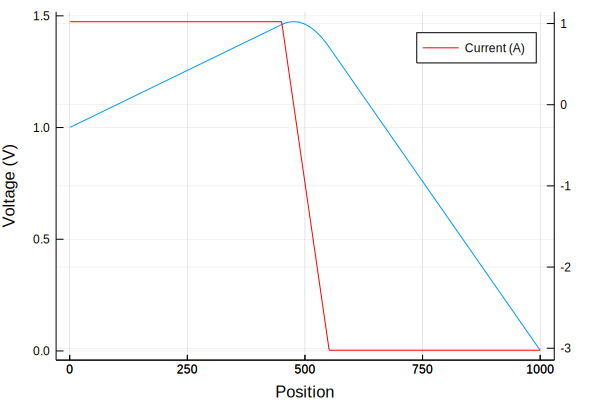

In [13]:
plot(x,legend=false,xlabel="Position",ylabel="Voltage (V)")
plt = twinx()
plot!(plt,A,label="Current (A)",color=:red)

### Question 1 - Does conductivity play a role now?

Yes, but only in the current calculation as shown, not in the solution of x.